# Capstone Project - The Battle of Neighborhoods

## Table of contents

### 1. Business Problem
### 2. Data Selection & Source
### 3. Methodology
### 3. Results & Decision
### 3. Conclusion

### Business Problem
The aim of this project is to find a safe and secure location for opening of Italian restaurants in the city of New York. New York is the most populous city in the United States with an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles (784 km2) which makes it the most densely populated major city in the United States(Wikipedia). New York City has the largest population of Italian Americans in the United States of America as well as North America.  Over 1.3 million Italians and Italian-Americans live in the greater New York City metro area, with about 800,000 living within one of the five New York City boroughs. For this big population the need to find and enjoy Italian cuisine is on the rise. We will make use of our data science tools to analyse data and focus on the safest borough and explore its neighborhoods to find the best italian restaurants in the city of New York. Also  we are going to cluster neighborhoods in order to recommend the best locations of opening italian restaurant and the best places to enjoy italian cuisine.

### Data Selection & Source
Based on definition of our problem, factors that will influence our decission are:

    Finding boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings
    Finding the most common venues for easy access
    Selecting the right neighbourhood within the borough
    
Data source: https://cocl.us/new_york_dataset &  https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

To explore and target recommended locations across different neighborhood boundaries we will access data through FourSquare API inerface and arrange them as a dataframe for visualization.

Foursquare API Data:

We will need data about different venues in different neighborhoods of that specific borough. In order to gain that information we will use "Foursquare" locational information. The Foursquare API allows application developers to interact with the Foursquare platform. The API itself is a RESTful set of addresses to which we can send requests. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighborhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighborhood. 

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

1. Neighborhood Names, Latitude, Longitude
2. Venue Name, ID, Ratings, Tips, Likes


### Methodology

The Methodology section will describe the main components of our analysis and predication system. The Methodology section comprises six stages:

1. Collect Inspection Data
2. Using Foursquare locating all venues filtered by Italian restaurants. Ratings, tips, and likes by users
3. Explore and Understand Data
4. Data preparation and preprocessing 
5. Modeling
6. Data Visualization using various Python libraries.



In [2]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium #import folium # map rendering library
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Libraries Loaded')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

In [32]:


#Define Foursquare Credentials and Version

CLIENT_ID = 'JN2HIR25PRUVQMFB24IFSAN2T34OJ5J2MH3SLYZPHKFTI1GV' # Foursquare ID
CLIENT_SECRET = 'UTXRXBM2QHW0E1DCF4LPW1I3Q2STV1UJ4MOLNRYOMNFQH0WC' # Foursquare Secret
VERSION = '20200629' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)



Your credentails:
CLIENT_ID: JN2HIR25PRUVQMFB24IFSAN2T34OJ5J2MH3SLYZPHKFTI1GV
CLIENT_SECRET:UTXRXBM2QHW0E1DCF4LPW1I3Q2STV1UJ4MOLNRYOMNFQH0WC


In [33]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format( venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [34]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [35]:
ny_data.shape

(306, 4)

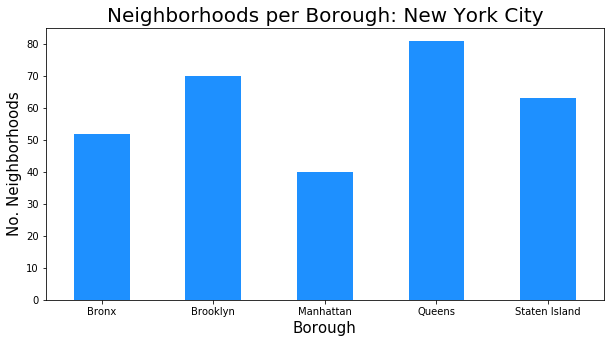

In [102]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: New York City', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [37]:

column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
['Bronx', '

( 68 / 306 ) Italian Resturants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Italian Resturants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Italian Resturants in Fort Greene, Brooklyn:3
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Italian Resturants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Italian Resturants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Italian Resturants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Italian Resturants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Italian Resturants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Italian Resturants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Italian Resturants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Italian Resturants in Howard Beach, Queens:3
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Italian Resturants in Corona, Queens:1
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Italian Resturants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Italian Resturants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Italian Resturants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Italian Resturants in Flushing, Queens:1
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Italian R

( 199 / 306 ) Italian Resturants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Italian Resturants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Italian Resturants in Rosebank, Staten Island:1
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Italian Resturants in West Brighton, Staten Island:2
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Italian Resturants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Italian Resturants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Italian Resturants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Italian Resturants in Port Richmond, 

( 260 / 306 ) Italian Resturants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Italian Resturants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Italian Resturants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Italian Resturants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Italian Resturants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Italian Resturants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Italian Resturants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Italian Resturants in Astoria Heights, Queens:2
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
(

In [38]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare


In [40]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv', index_col=[0])
print(italian_rest_ny.columns.tolist())
italian_rest_ny.tail()

['Borough', 'Neighborhood', 'ID', 'Name']


,Borough,Neighborhood,ID,Name
216,Queens,Sunnyside Gardens,5699aa86498ef437b2fd7102,Zio Luigi
217,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
218,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
219,Staten Island,Prince's Bay,4c091311a1b32d7f5efb96f0,Certo's Gourmet Foods & Caterers
220,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [41]:
italian_rest_ny.shape

(221, 4)

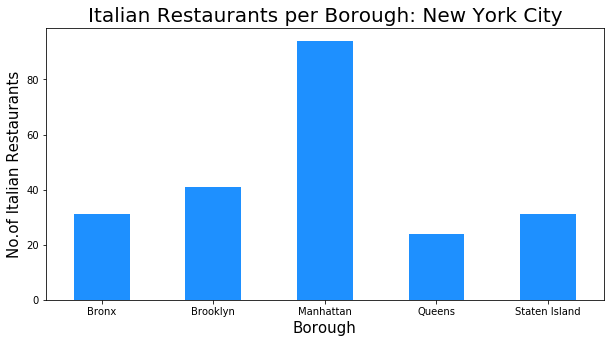

In [108]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Italian Restaurants per Borough: New York City', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

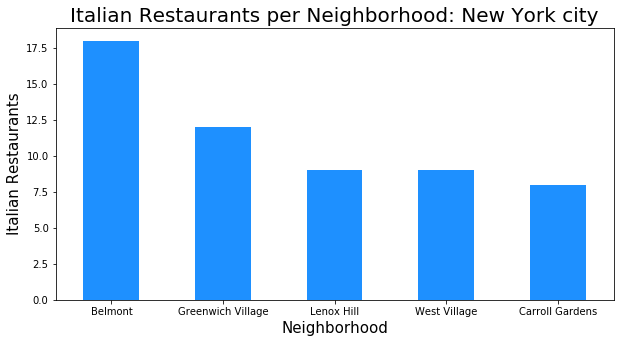

In [107]:
NOofNeigh = 5
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Neighborhood: New York city', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [44]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
5,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
6,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
7,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
8,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
9,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
10,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
11,Bronx,Belmont,4bc22a22920eb713bcc51b2c,Tra Di Noi
12,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
13,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato
14,Bronx,Belmont,4c9b9e7b9c663704b90463fd,Gerbasi Ristorante


In [45]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5efaaf2328da647940b36428'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}, {'label': 'entrance', 'lat': 40.900601, 'lng': -73.867611}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}],

{'meta': {'code': 200, 'requestId': '5efaad8c353f133543f30afb'}, 'response': {'venue': {'id': '4b47f069f964a5208c4426e3', 'name': 'Pasta Pasta', 'contact': {'phone': '7188929634', 'formattedPhone': '(718) 892-9634'}, 'location': {'address': '2023 Williamsbridge Rd', 'lat': 40.85478806485715, 'lng': -73.85492881053774, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85478806485715, 'lng': -73.85492881053774}, {'label': 'entrance', 'lat': 40.854792, 'lng': -73.855184}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2023 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pasta-pasta/4b47f069f964a5208c4426e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified'

{'meta': {'code': 200, 'requestId': '5efaaead32a8a96285bf17a2'}, 'response': {'venue': {'id': '4b10591af964a5205f6e23e3', 'name': "Patricia's", 'contact': {'phone': '7184099069', 'formattedPhone': '(718) 409-9069', 'twitter': 'patriciasnyc'}, 'location': {'address': '1082 Morris Park Ave', 'lat': 40.84931298339339, 'lng': -73.85353576737785, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84931298339339, 'lng': -73.85353576737785}, {'label': 'entrance', 'lat': 40.849229, 'lng': -73.853395}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1082 Morris Park Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patricias/4b10591af964a5205f6e23e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary'

                         ID                 Name  Likes  Rating  Tips
0  4acf80aef964a52025d420e3  Tino's Delicatessen    145     9.2    48
( 6 / 221 ) processed
{'meta': {'code': 200, 'requestId': '5efaaeee8d58ab258e9ff1ac'}, 'response': {'venue': {'id': '4af71916f964a520cf0522e3', 'name': "Michaelangelo's Coal Fired Brick Oven Pizza Restaurant", 'contact': {'phone': '3475907650', 'formattedPhone': '(347) 590-7650'}, 'location': {'address': '2477 Arthur Ave', 'lat': 40.85741189614754, 'lng': -73.88646821282298, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85741189614754, 'lng': -73.88646821282298}, {'label': 'entrance', 'lat': 40.857301, 'lng': -73.886231}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2477 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/michaelangelos-coal-fired-brick-oven-pizza-restaurant/4af71916f964a520cf0522e3', 'categories': [{'id': '4bf58dd8

{'meta': {'code': 200, 'requestId': '5efaaf3748e3cc6861aba744'}, 'response': {'venue': {'id': '59050f51b23dfa5f6649e678', 'name': 'Arthur Avenue Fiasco', 'contact': {'phone': '7186180806', 'formattedPhone': '(718) 618-0806'}, 'location': {'address': '2376 Arthur Ave', 'crossStreet': '187th street', 'lat': 40.854844, 'lng': -73.887908, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854844, 'lng': -73.887908}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2376 Arthur Ave (187th street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/arthur-avenue-fiasco/59050f51b23dfa5f6649e678', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'likes'

{'meta': {'code': 200, 'requestId': '5efaac763b1954422f3a9acb'}, 'response': {'venue': {'id': '4af0fa29f964a52060e021e3', 'name': "Antonio's Trattoria", 'contact': {'phone': '7187336630', 'formattedPhone': '(718) 733-6630'}, 'location': {'address': '2370 Belmont Ave', 'lat': 40.854082862115455, 'lng': -73.88661644989108, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854082862115455, 'lng': -73.88661644989108}, {'label': 'entrance', 'lat': 40.854251, 'lng': -73.886599}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2370 Belmont Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/antonios-trattoria/4af0fa29f964a52060e021e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '5efaaf44f1f0896dbd1d5b58'}, 'response': {'venue': {'id': '4bc22a22920eb713bcc51b2c', 'name': 'Tra Di Noi', 'contact': {'phone': '7182951784', 'formattedPhone': '(718) 295-1784', 'twitter': 'zeroottonovebrx'}, 'location': {'address': '622 E 187th St', 'lat': 40.855139534007634, 'lng': -73.88679442998631, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855139534007634, 'lng': -73.88679442998631}, {'label': 'entrance', 'lat': 40.855035, 'lng': -73.886799}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['622 E 187th St', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tra-di-noi/4bc22a22920eb713bcc51b2c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True

{'meta': {'code': 200, 'requestId': '5efaaee6f5be0232e5142be6'}, 'response': {'venue': {'id': '4c79d294278eb713f6a05580', 'name': 'Cafe al Mercato', 'contact': {'phone': '7183647681', 'formattedPhone': '(718) 364-7681'}, 'location': {'address': '2344 Arthur Ave', 'lat': 40.85417649340613, 'lng': -73.88808455700543, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85417649340613, 'lng': -73.88808455700543}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2344 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-al-mercato/4c79d294278eb713f6a05580', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'likes': {'count': 10, 'groups'

{'meta': {'code': 200, 'requestId': '5efaaed4882fc7644eeebd92'}, 'response': {'venue': {'id': '4b5514c4f964a5207cda27e3', 'name': "Enzo's", 'contact': {'phone': '7187334455', 'formattedPhone': '(718) 733-4455'}, 'location': {'address': '2339 Arthur Ave', 'lat': 40.854354554251444, 'lng': -73.88864359312625, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854354554251444, 'lng': -73.88864359312625}, {'label': 'entrance', 'lat': 40.854339, 'lng': -73.888759}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2339 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/enzos/4b5514c4f964a5207cda27e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tip

{'meta': {'code': 200, 'requestId': '5efaaef907a2fd0bac778c19'}, 'response': {'venue': {'id': '4aa193d5f964a520124120e3', 'name': "Mario's Restaurant & Catering", 'contact': {'phone': '7185841188', 'formattedPhone': '(718) 584-1188'}, 'location': {'address': '2342 Arthur Ave', 'crossStreet': 'at Crescent Ave', 'lat': 40.854243777661196, 'lng': -73.88843667516853, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854243777661196, 'lng': -73.88843667516853}, {'label': 'entrance', 'lat': 40.854189, 'lng': -73.88858}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2342 Arthur Ave (at Crescent Ave)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/marios-restaurant--catering/4aa193d5f964a520124120e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categ

{'meta': {'code': 200, 'requestId': '5efaae944f30dd22c5bc6684'}, 'response': {'venue': {'id': '53ff939c498e6b601dfa3979', 'name': 'San Gennaro Ristorante', 'contact': {'phone': '7185620129', 'formattedPhone': '(718) 562-0129'}, 'location': {'address': '2329 Arthur Ave', 'lat': 40.854217, 'lng': -73.8891, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854217, 'lng': -73.8891}, {'label': 'entrance', 'lat': 40.854126, 'lng': -73.88894}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2329 Arthur Ave', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/san-gennaro-ristorante/53ff939c498e6b601dfa3979', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '5efaad92353f133543f31903'}, 'response': {'venue': {'id': '4bc67f1104e8b713a833362d', 'name': "Ann & Tony's - An Original Arthur Avenue Restaurant", 'contact': {'phone': '7189331469', 'formattedPhone': '(718) 933-1469', 'twitter': 'annandtonys'}, 'location': {'address': '2407 Arthur Ave', 'crossStreet': 'at E.187th Street', 'lat': 40.855704465427415, 'lng': -73.88744918407676, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855704465427415, 'lng': -73.88744918407676}, {'label': 'entrance', 'lat': 40.855798, 'lng': -73.88751}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2407 Arthur Ave (at E.187th Street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ann--tonys--an-original-arthur-avenue-restaurant/4bc67f1104e8b713a833362d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', '

{'meta': {'code': 200, 'requestId': '5efaaefb07a2fd0bac778e4b'}, 'response': {'venue': {'id': '57005f75498ed225ade7266d', 'name': 'Tapas Italiano Fusion Restaurant', 'contact': {'phone': '6462362548', 'formattedPhone': '(646) 236-2548'}, 'location': {'address': '2363 Arthur Ave', 'crossStreet': 'East 186th Street', 'lat': 40.854933, 'lng': -73.888473, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854933, 'lng': -73.888473}, {'label': 'entrance', 'lat': 40.854855, 'lng': -73.888317}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2363 Arthur Ave (East 186th Street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tapas-italiano-fusion-restaurant/57005f75498ed225ade7266d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian

{'meta': {'code': 200, 'requestId': '5efaaed6882fc7644eeec10f'}, 'response': {'venue': {'id': '4c9e1ef2542b224b70a3f09f', 'name': 'Lucca Italian Restaurant', 'contact': {'phone': '7188928282', 'formattedPhone': '(718) 892-8282'}, 'location': {'address': '3019 Westchester Ave', 'crossStreet': 'Hobart Ave', 'lat': 40.847676, 'lng': -73.831834, 'labeledLatLngs': [{'label': 'display', 'lat': 40.847676, 'lng': -73.831834}, {'label': 'entrance', 'lat': 40.84769, 'lng': -73.831699}], 'postalCode': '10461', 'cc': 'US', 'neighborhood': 'Pelham Bay', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3019 Westchester Ave (Hobart Ave)', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucca-italian-restaurant/4c9e1ef2542b224b70a3f09f', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/foo

{'meta': {'code': 200, 'requestId': '5efaaeed499f43407aa23a70'}, 'response': {'venue': {'id': '4b85b6b3f964a5209b6e31e3', 'name': "Giovanni's Italian Restaurant", 'contact': {'phone': '7188924340', 'formattedPhone': '(718) 892-4340'}, 'location': {'address': '3209 Westchester Ave', 'lat': 40.85178560311938, 'lng': -73.82978599125016, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85178560311938, 'lng': -73.82978599125016}, {'label': 'entrance', 'lat': 40.851846, 'lng': -73.829821}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3209 Westchester Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/giovannis-italian-restaurant/4b85b6b3f964a5209b6e31e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}

{'meta': {'code': 200, 'requestId': '5efaad696e5c0a4648a12b5a'}, 'response': {'venue': {'id': '4bb7c582cf2fc9b6dfc69e02', 'name': "Genio's Trattoria", 'contact': {'phone': '7188231646', 'formattedPhone': '(718) 823-1646'}, 'location': {'address': '1805 Edison Ave', 'lat': 40.847087, 'lng': -73.832349, 'labeledLatLngs': [{'label': 'display', 'lat': 40.847087, 'lng': -73.832349}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1805 Edison Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/genios-trattoria/4bb7c582cf2fc9b6dfc69e02', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}

{'meta': {'code': 200, 'requestId': '5efaaf08c12be54ba2877f41'}, 'response': {'venue': {'id': '4bfd8d06f61dc9b669309fde', 'name': "Tiny's Pizza & Pasta", 'contact': {'phone': '7182938346', 'formattedPhone': '(718) 293-8346'}, 'location': {'address': '1113 Grant Ave', 'lat': 40.8309295822695, 'lng': -73.91662582679406, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8309295822695, 'lng': -73.91662582679406}, {'label': 'entrance', 'lat': 40.831001, 'lng': -73.91661}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1113 Grant Ave', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tinys-pizza--pasta/4bfd8d06f61dc9b669309fde', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': F

{'meta': {'code': 200, 'requestId': '5efaad6bb5ad90183f3c26ec'}, 'response': {'venue': {'id': '4ad62c95f964a5208d0521e3', 'name': 'Zio Toto', 'contact': {'phone': '7182388042', 'formattedPhone': '(718) 238-8042'}, 'location': {'address': '8407 3rd Ave', 'crossStreet': 'btwn 84th & 85th St', 'lat': 40.62479085034183, 'lng': -74.03055087900958, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62479085034183, 'lng': -74.03055087900958}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8407 3rd Ave (btwn 84th & 85th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/zio-toto/4ad62c95f964a5208d0521e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16d94173

{'meta': {'code': 200, 'requestId': '5efaaf6ad0415c07c67f940d'}, 'response': {'venue': {'id': '4e732dff45dd41e9ccce1987', 'name': "Giacomo's Wood Fired Pizza & Trattoria", 'contact': {'phone': '7184396993', 'formattedPhone': '(718) 439-6993'}, 'location': {'address': '7902 3rd Ave', 'lat': 40.62853486510589, 'lng': -74.02905124266296, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62853486510589, 'lng': -74.02905124266296}, {'label': 'entrance', 'lat': 40.628483, 'lng': -74.029154}], 'postalCode': '11209', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7902 3rd Ave', 'Staten Island, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/giacomos-wood-fired-pizza--trattoria/4e732dff45dd41e9ccce1987', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 

{'meta': {'code': 200, 'requestId': '5efaae92d2bf83199c496760'}, 'response': {'venue': {'id': '4e30a139483bb3fdc436a7e3', 'name': 'Villa Fiorita', 'contact': {'phone': '7188377950', 'formattedPhone': '(718) 837-7950'}, 'location': {'address': '7720 18th Ave', 'lat': 40.611931, 'lng': -73.997854, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611931, 'lng': -73.997854}, {'label': 'entrance', 'lat': 40.611851, 'lng': -73.997718}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7720 18th Ave', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/villa-fiorita/4e30a139483bb3fdc436a7e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'like

0  4ae23a80f964a5200c8c21e3  il Colosseo     30     7.7    22
( 37 / 221 ) processed
{'meta': {'code': 200, 'requestId': '5efaad0130567d545ec224f2'}, 'response': {'venue': {'id': '5095a98ae4b0038a605e6f45', 'name': 'Cafe Lore', 'contact': {'phone': '7184927100', 'formattedPhone': '(718) 492-7100', 'twitter': 'cafelore1'}, 'location': {'address': '4601 4th Ave', 'crossStreet': '46th Street', 'lat': 40.648474, 'lng': -74.01008900000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.648474, 'lng': -74.01008900000001}, {'label': 'entrance', 'lat': 40.648525, 'lng': -74.010174}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4601 4th Ave (46th Street)', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-lore/5095a98ae4b0038a605e6f45', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'ico

{'meta': {'code': 200, 'requestId': '5efaaf6bd0415c07c67f95fe'}, 'response': {'venue': {'id': '4ff37cb9e4b0b8fda883be7f', 'name': "Adelina's", 'contact': {'phone': '3477630152', 'formattedPhone': '(347) 763-0152', 'twitter': 'adelinas_wine', 'facebook': '348757038525931', 'facebookUsername': 'AdelinasBK', 'facebookName': "Adelina's"}, 'location': {'address': '159 Greenpoint Ave', 'crossStreet': 'at Leonard St.', 'lat': 40.730301301138475, 'lng': -73.95335193287592, 'labeledLatLngs': [{'label': 'display', 'lat': 40.730301301138475, 'lng': -73.95335193287592}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['159 Greenpoint Ave (at Leonard St.)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/adelinas_wine', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.n

{'meta': {'code': 200, 'requestId': '5efaaee57f80693691cd6673'}, 'response': {'venue': {'id': '4ad8c329f964a520731421e3', 'name': "Joe's of Avenue U", 'contact': {'phone': '7184499285', 'formattedPhone': '(718) 449-9285'}, 'location': {'address': '287 Avenue U', 'lat': 40.596970812269824, 'lng': -73.9736772701698, 'labeledLatLngs': [{'label': 'display', 'lat': 40.596970812269824, 'lng': -73.9736772701698}, {'label': 'entrance', 'lat': 40.597039, 'lng': -73.973681}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['287 Avenue U', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joes-of-avenue-u/4ad8c329f964a520731421e3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': F

{'meta': {'code': 200, 'requestId': '5efaaf36cd0a802e768fa33c'}, 'response': {'venue': {'id': '5a0740a3e1f22816d11723d5', 'name': 'Lillo', 'contact': {'phone': '3477630899', 'formattedPhone': '(347) 763-0899'}, 'location': {'address': '331 Henry Street', 'lat': 40.690199941477445, 'lng': -73.99654010450837, 'labeledLatLngs': [{'label': 'display', 'lat': 40.690199941477445, 'lng': -73.99654010450837}], 'postalCode': '11201', 'cc': 'US', 'neighborhood': 'Cobble Hill', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['331 Henry Street', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lillo/5a0740a3e1f22816d11723d5', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1e0931735', 'name': 'Coffee Shop'

{'meta': {'code': 200, 'requestId': '5efaae0334f8b76b9543490e'}, 'response': {'venue': {'id': '5044f749e4b0dd909d2cc123', 'name': 'Table 87', 'contact': {'phone': '7187979300', 'formattedPhone': '(718) 797-9300'}, 'location': {'address': '87 Atlantic Ave', 'lat': 40.69116378701994, 'lng': -73.99744297710961, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69116378701994, 'lng': -73.99744297710961}, {'label': 'entrance', 'lat': 40.691219, 'lng': -73.997355}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['87 Atlantic Ave', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/table-87/5044f749e4b0dd909d2cc123', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c

{'meta': {'code': 200, 'requestId': '5efaaf36cd0a802e768fa4da'}, 'response': {'venue': {'id': '49c4ff90f964a520da561fe3', 'name': 'Fragole', 'contact': {'phone': '7185227133', 'formattedPhone': '(718) 522-7133', 'twitter': 'fragoleny', 'facebook': '223164304439051', 'facebookName': 'Fragole Restaurant'}, 'location': {'address': '394 Court St', 'crossStreet': 'btwn 1st Pl & Carroll St.', 'lat': 40.680805, 'lng': -73.99689, 'labeledLatLngs': [{'label': 'display', 'lat': 40.680805, 'lng': -73.99689}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['394 Court St (btwn 1st Pl & Carroll St.)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/fragoleny', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5efaaf4748e3cc6861abc672'}, 'response': {'venue': {'id': '506cb4a8e4b02db545b4bf5c', 'name': "Claudine's", 'contact': {'phone': '7182374992', 'formattedPhone': '(718) 237-4992', 'facebook': '496394810370638', 'facebookName': "Claudine's"}, 'location': {'address': '311 Smith St', 'crossStreet': 'Smith St & Union St', 'lat': 40.681352187513205, 'lng': -73.99410672670723, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681352187513205, 'lng': -73.99410672670723}, {'label': 'entrance', 'lat': 40.681307, 'lng': -73.99402}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['311 Smith St (Smith St & Union St)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/claudines/506cb4a8e4b02db545b4bf5c', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix':

                         ID              Name  Likes  Rating  Tips
0  4a32d7ebf964a520a29a1fe3  Enoteca on Court     60     7.2    27
( 48 / 221 ) processed
{'meta': {'code': 200, 'requestId': '5efaae96d2bf83199c496ebb'}, 'response': {'venue': {'id': '5766ad56498ebf269c3737d2', 'name': 'Gersi', 'contact': {'phone': '3478895077', 'formattedPhone': '(347) 889-5077', 'twitter': 'gersirestaurant'}, 'location': {'address': '316 Court St', 'crossStreet': 'Sackett Street', 'lat': 40.68337949868895, 'lng': -73.99549228030504, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68337949868895, 'lng': -73.99549228030504}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['316 Court St (Sackett Street)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gersi/5766ad56498ebf269c3737d2', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurant

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5efaaf0dc12be54ba2878948'}, 'response': {}}


KeyError: 'venue'

In [46]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [47]:
italian_rest_stats_ny.shape

(50, 7)

In [48]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [49]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [50]:
italian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,36.060000,7.456000,17.140000
std,35.150063,1.717754,13.460464
min,0.000000,0.000000,0.000000
25%,10.250000,7.225000,6.000000
50%,22.500000,7.750000,13.000000
75%,46.000000,8.175000,26.750000
max,145.000000,9.400000,48.000000


In [51]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                145
Rating                               9.2
Tips                                  48
Name: 5, dtype: object

In [52]:
# Resturant with maximum Ratings
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a98aed16a59506d7a60d67c
Name                          Carmenta’s
Likes                                 58
Rating                               9.4
Tips                                  21
Name: 40, dtype: object

In [53]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                145
Rating                               9.2
Tips                                  48
Name: 5, dtype: object

In [54]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
3,Bushwick,9.4
14,Pelham Gardens,8.7
17,Woodlawn,8.6
11,Morris Park,8.5
6,Cobble Hill,8.5
5,City Island,8.2
10,Greenpoint,7.9
9,Gravesend,7.9
2,Bensonhurst,7.9
16,Sunset Park,7.6


In [55]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,7.710000
0,Bronx,7.286667


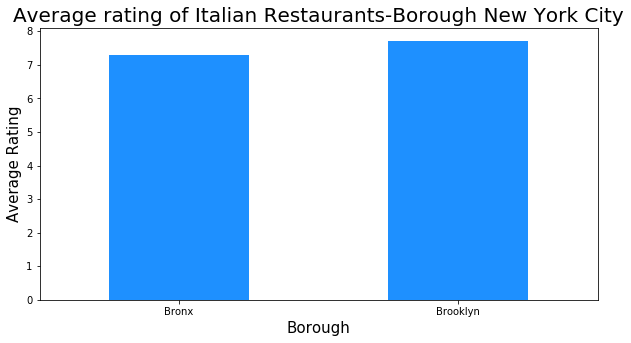

In [106]:
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Restaurants-Borough New York City', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [57]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
3,Bushwick,9.4
5,City Island,8.2
6,Cobble Hill,8.5
11,Morris Park,8.5
14,Pelham Gardens,8.7
17,Woodlawn,8.6


In [58]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bushwick,40.698116,-73.925258,9.4
1,Bronx,City Island,40.847247,-73.786488,8.2
2,Brooklyn,Cobble Hill,40.687920,-73.998561,8.5
3,Bronx,Morris Park,40.847549,-73.850402,8.5
4,Bronx,Pelham Gardens,40.862966,-73.841612,8.7
5,Bronx,Woodlawn,40.898273,-73.867315,8.6


In [59]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [60]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Results& Decision
Here we can conclude that borough wise Manhttan has most Italian restaurant. On the other hand Bronx has as twice as many in half the number of restaurants in manhattan. After analyzing the data we found that Bronx's Belmont neighborhood has more restaurants than Manhattan neighbourhood Lenox Hill. Considering Likes and Tips, Belmont is much ahead out of other neighborhoods. Most iportantly, Bushwick neighborhood has highest average rating than other neighborhood in Brooklyn. In Bronx, Woodlawn and Pelham Garden's restaurant have highest average ratings than other neighbprhood. 

Finally, we drew the conclusion that Bronx is the best option to open an Italian restaurants. In Bronx, most restaurants in neighborhood have on avearge 8.5 rating out of 10. Finally, I would go to Belmont in Bronx for the best Italian food based on 145 likes.

### Conclusion
To sum up, finding best places to open italian restaurant throughout the city in New York we included boundaries, latitude, longitude, restaurants, and restaurant ratings and sorted the most common venues for easy access and finally selected the right neighborhood within the borough .Although in this report, it demonstrates the relations between location and ratings, but ratings might not reflect the operation status of the restaurant. A restaurant with a high rating could still be unprofitable, which is unsuccessful from a business perspective As a final note, all of the above analysis is depended on the adequacy and accuracy of Four Square data. To suggest more practical and profitable ideas, the relationship between customer reactions and financial performance should be evaluated.